In [ ]:
import pandas as pd 
import numpy as np 
import re


In [ ]:
%%capture
!pip install transformers --upgrade
!pip install mosestokenizer
!pip install sentencepiece
!pip install ast

In [ ]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from google.colab import drive
import re
from bs4 import BeautifulSoup

In [ ]:
#alternate sentiment model 
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
device = torch.device("cuda")
model = model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
def predict_sentiment(text):  
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt').to(device)
  output = model(**encoded_input)
  scores = output[0][0].detach().cpu().numpy()
  scores = softmax(scores)
  score = 0
  for i in range(len(scores)):
    score += (i-1)*scores[i]
  return score

In [ ]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/EliData/EliDataModified.csv')

In [ ]:
#quickly creating a sentiment dict and embedding dict 
sentiment_dict = {}
for response, group in generations.groupby("response"):
  sentiment_dict[response] = predict_sentiment(response)

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=119d80cd666b7c0d69be281cf3a28fff20ecf445122baf166429cd576b2d4752
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [ ]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(sentiment_dict[response])
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for id in exploration:
  # if .7 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

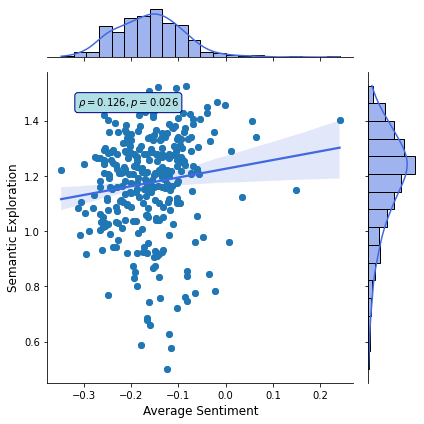

In [ ]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

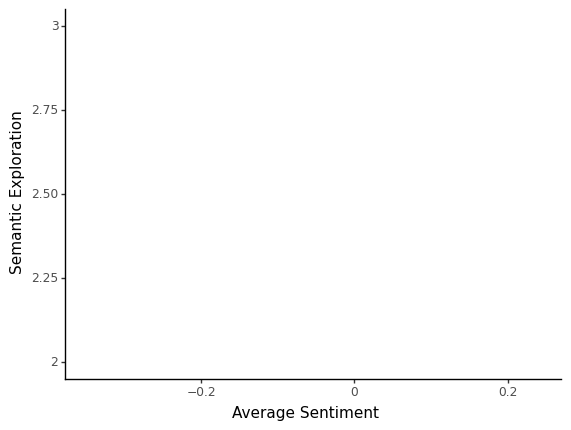

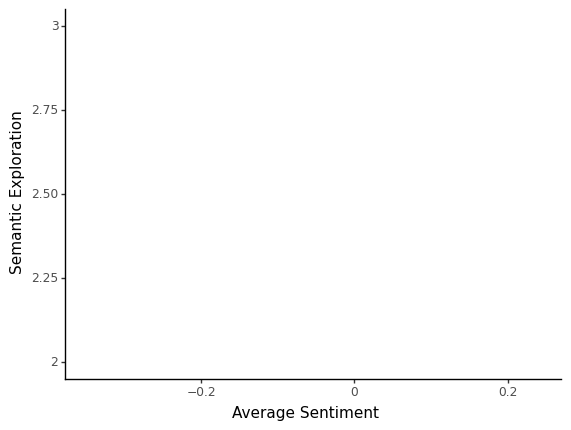

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [ ]:
generations

Unnamed: 0  vignette_name  generation_number  \
0              0              1                  1   
1              1              1                  2   
2              2              1                  3   
3              3              1                  4   
4              4              1                  5   
...          ...            ...                ...   
9315        9315             18                  1   
9316        9316             18                  2   
9317        9317             18                  3   
9318        9318             18                  4   
9319        9319             18                  5   

                                               response  reflection_score   id  
0                         Ask family/friends for money.          0.850000    1  
1                    Try and find it cheaper elsewhere.          0.803333    1  
2                                      Take out a loan.          0.473333    1  
3                                       Pay it anyways.          0.776667    1  
4              Try and haggle with insurance or seller.          0.583333    1  
...                                                 ...               ...  ...  
9315               keep going and ignore the competitor          0.413333  311  
9316                          stop and try to help them          0.890000  311  
9317  find a way to send a message to people that so...          0.830000  311  
9318     stop and also try and get other people to stop          0.576667  311  
9319  let people know at the next check point what w...          0.943333  311  

[9320 rows x 6 columns]

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    e = 0
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        e += dist(embeddings[i], embeddings[j])
    exploration[pnum].append(e/len(embeddings))
    exp.append(e/len(embeddings))
    nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

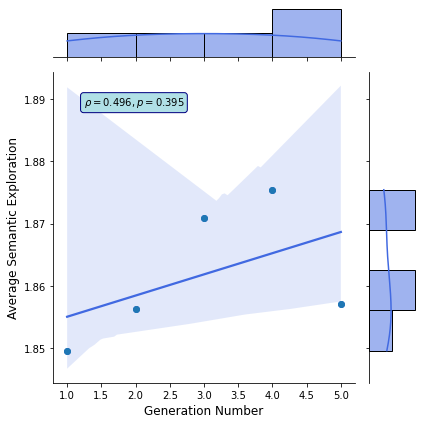

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

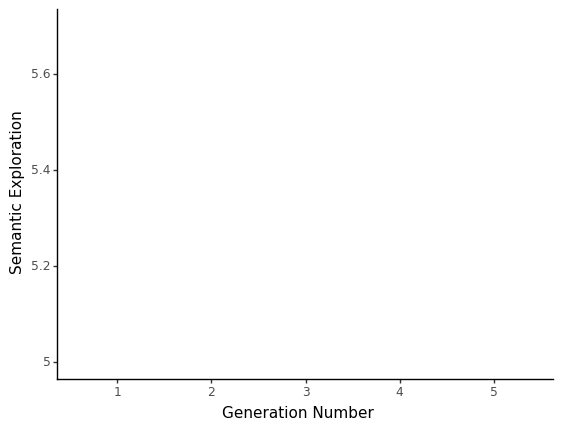

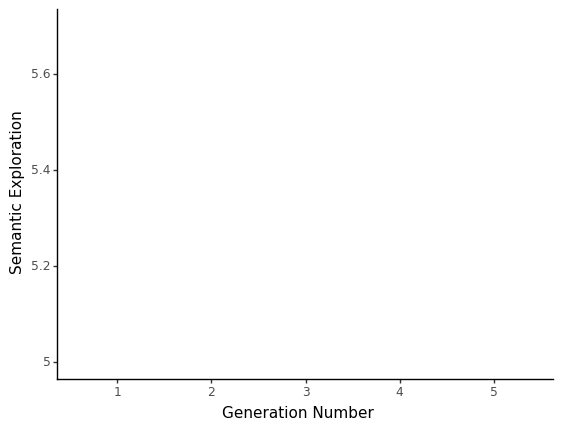

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    vectordic.get(pnum).append(embeddings)


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

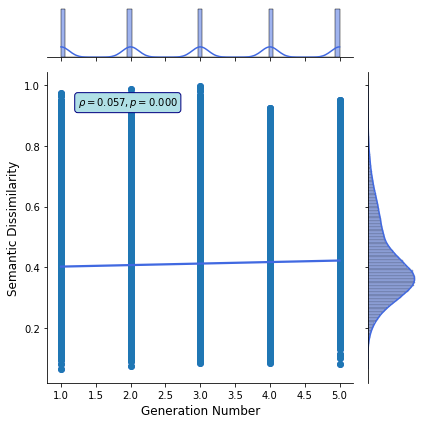

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

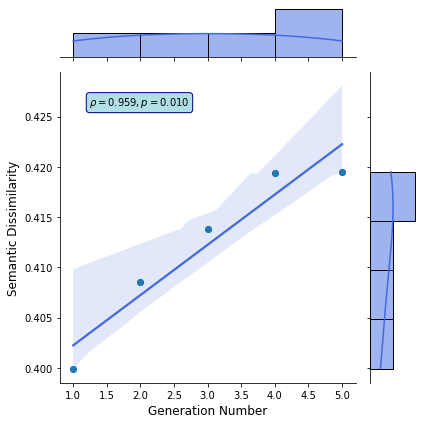

In [ ]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

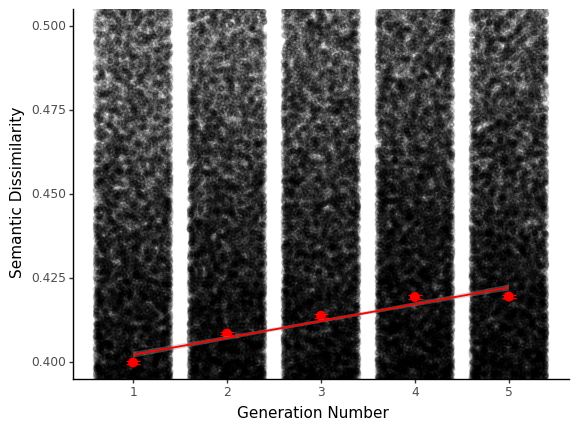

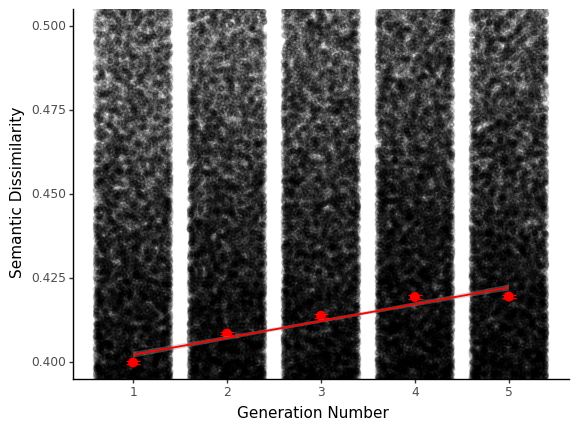

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**

In [ ]:
#average goodness rating per possibility 
scores = [[] for i in range(5)]
nums = [i for i in range(5)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

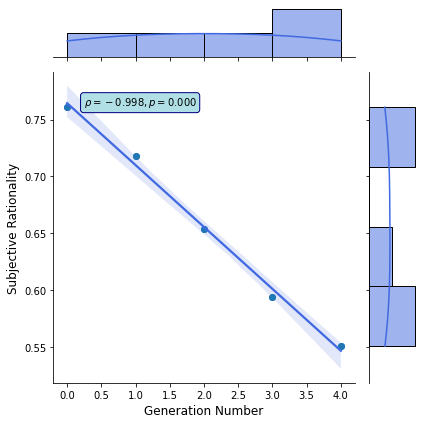

In [ ]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


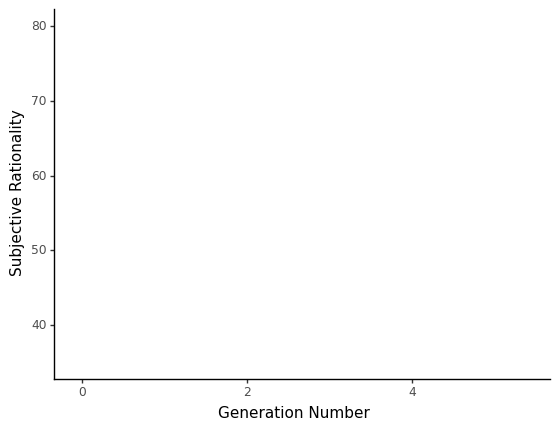

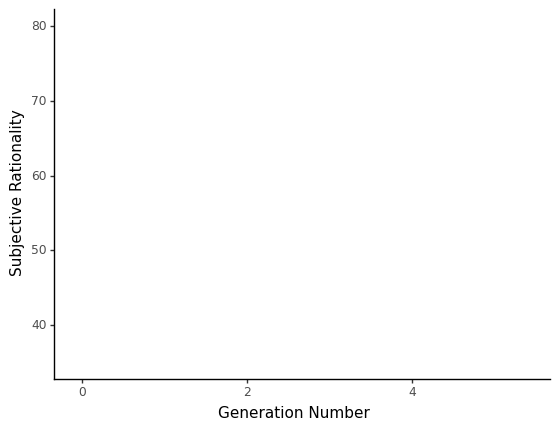

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [ ]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in generations.groupby('id'):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = sentiment_dict[generation]
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

In [ ]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

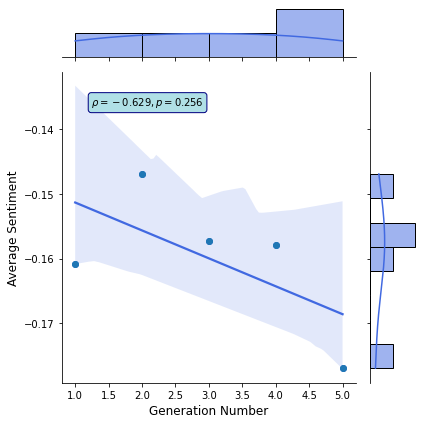

In [ ]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


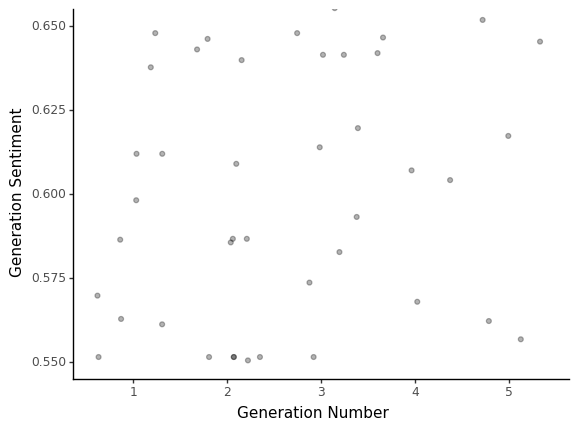

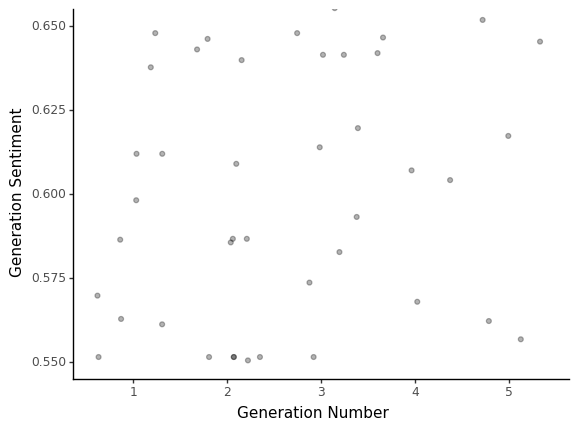

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [ ]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [ ]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [ ]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [ ]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.820578306125866, 2: 2.8073681564187614, 3: 2.7588918892509193, 4: 2.7564898533733513, 5: 2.7676695689918778}


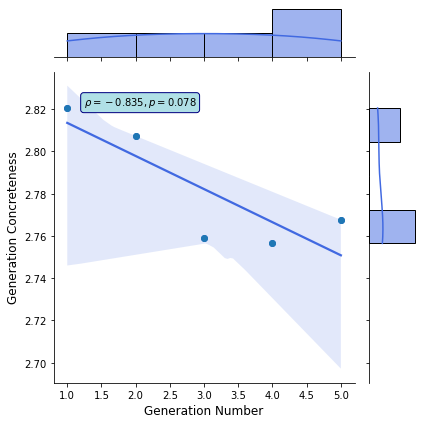

In [ ]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

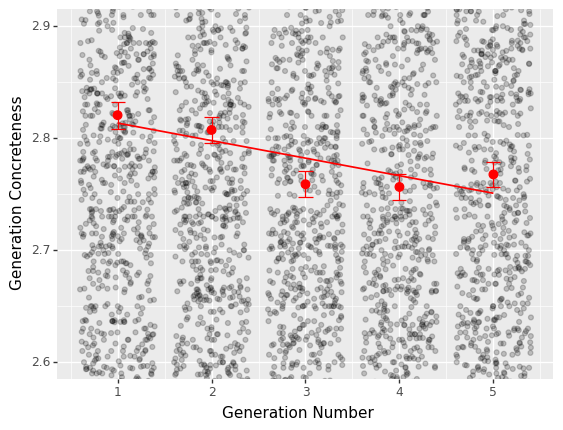

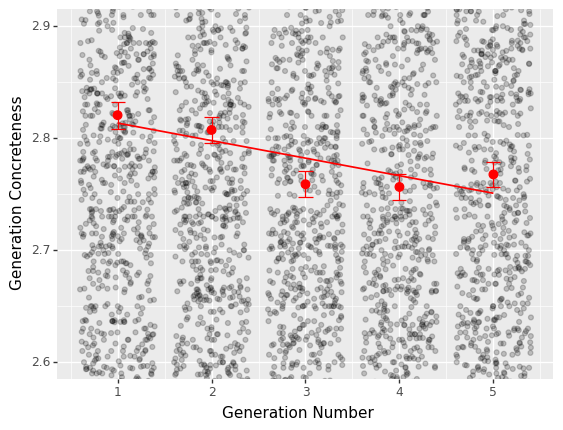

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

7961

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


  1%|          | 1/100 [00:01<02:46,  1.69s/it]

0


  2%|▏         | 2/100 [00:03<02:43,  1.67s/it]

1


  3%|▎         | 3/100 [00:04<02:40,  1.66s/it]

2


  4%|▍         | 4/100 [00:06<02:39,  1.67s/it]

3


  5%|▌         | 5/100 [00:08<02:36,  1.65s/it]

4


  6%|▌         | 6/100 [00:09<02:35,  1.66s/it]

5


  7%|▋         | 7/100 [00:11<02:33,  1.65s/it]

6


  8%|▊         | 8/100 [00:13<02:31,  1.65s/it]

7


  9%|▉         | 9/100 [00:14<02:31,  1.66s/it]

8


 10%|█         | 10/100 [00:16<02:29,  1.66s/it]

9


 11%|█         | 11/100 [00:18<02:26,  1.65s/it]

10


 12%|█▏        | 12/100 [00:19<02:25,  1.65s/it]

11


 13%|█▎        | 13/100 [00:21<02:24,  1.66s/it]

12


 14%|█▍        | 14/100 [00:23<02:21,  1.65s/it]

13


 15%|█▌        | 15/100 [00:24<02:20,  1.65s/it]

14


 16%|█▌        | 16/100 [00:26<02:18,  1.65s/it]

15


 17%|█▋        | 17/100 [00:28<02:16,  1.65s/it]

16


 18%|█▊        | 18/100 [00:30<02:23,  1.75s/it]

17


 19%|█▉        | 19/100 [00:32<02:29,  1.85s/it]

18


 20%|██        | 20/100 [00:33<02:23,  1.79s/it]

19


 21%|██        | 21/100 [00:35<02:17,  1.74s/it]

20


 22%|██▏       | 22/100 [00:37<02:14,  1.72s/it]

21


 23%|██▎       | 23/100 [00:38<02:10,  1.70s/it]

22


 24%|██▍       | 24/100 [00:40<02:07,  1.68s/it]

23


 25%|██▌       | 25/100 [00:42<02:05,  1.67s/it]

24


 26%|██▌       | 26/100 [00:43<02:03,  1.67s/it]

25


 27%|██▋       | 27/100 [00:45<02:01,  1.66s/it]

26


 28%|██▊       | 28/100 [00:47<01:58,  1.65s/it]

27


 29%|██▉       | 29/100 [00:48<01:57,  1.66s/it]

28


 30%|███       | 30/100 [00:50<01:55,  1.65s/it]

29


 31%|███       | 31/100 [00:51<01:53,  1.65s/it]

30


 32%|███▏      | 32/100 [00:53<01:52,  1.65s/it]

31


 33%|███▎      | 33/100 [00:55<01:50,  1.65s/it]

32


 34%|███▍      | 34/100 [00:56<01:48,  1.65s/it]

33


 35%|███▌      | 35/100 [00:58<01:46,  1.64s/it]

34


 36%|███▌      | 36/100 [01:00<01:45,  1.65s/it]

35


 37%|███▋      | 37/100 [01:01<01:44,  1.65s/it]

36


 38%|███▊      | 38/100 [01:03<01:42,  1.65s/it]

37


 39%|███▉      | 39/100 [01:05<01:40,  1.64s/it]

38


 40%|████      | 40/100 [01:06<01:38,  1.64s/it]

39


 41%|████      | 41/100 [01:08<01:36,  1.64s/it]

40


 42%|████▏     | 42/100 [01:10<01:35,  1.65s/it]

41


 43%|████▎     | 43/100 [01:11<01:33,  1.64s/it]

42


 44%|████▍     | 44/100 [01:13<01:32,  1.64s/it]

43


 45%|████▌     | 45/100 [01:14<01:30,  1.64s/it]

44


 46%|████▌     | 46/100 [01:16<01:33,  1.74s/it]

45


 47%|████▋     | 47/100 [01:18<01:30,  1.71s/it]

46


 48%|████▊     | 48/100 [01:20<01:27,  1.69s/it]

47


 49%|████▉     | 49/100 [01:21<01:26,  1.69s/it]

48


 50%|█████     | 50/100 [01:23<01:23,  1.67s/it]

49


 51%|█████     | 51/100 [01:25<01:21,  1.66s/it]

50


 52%|█████▏    | 52/100 [01:26<01:20,  1.68s/it]

51


 53%|█████▎    | 53/100 [01:28<01:18,  1.67s/it]

52


 54%|█████▍    | 54/100 [01:30<01:16,  1.67s/it]

53


 55%|█████▌    | 55/100 [01:31<01:14,  1.66s/it]

54


 56%|█████▌    | 56/100 [01:33<01:12,  1.65s/it]

55


 57%|█████▋    | 57/100 [01:35<01:11,  1.66s/it]

56


 58%|█████▊    | 58/100 [01:36<01:09,  1.65s/it]

57


 59%|█████▉    | 59/100 [01:38<01:07,  1.65s/it]

58


 60%|██████    | 60/100 [01:40<01:06,  1.66s/it]

59


 61%|██████    | 61/100 [01:41<01:04,  1.66s/it]

60


 62%|██████▏   | 62/100 [01:43<01:02,  1.66s/it]

61


 63%|██████▎   | 63/100 [01:45<01:01,  1.65s/it]

62


 64%|██████▍   | 64/100 [01:46<00:59,  1.64s/it]

63


 65%|██████▌   | 65/100 [01:48<00:57,  1.65s/it]

64


 66%|██████▌   | 66/100 [01:50<00:56,  1.65s/it]

65


 67%|██████▋   | 67/100 [01:51<00:54,  1.66s/it]

66


 68%|██████▊   | 68/100 [01:53<00:53,  1.66s/it]

67


 69%|██████▉   | 69/100 [01:55<00:51,  1.66s/it]

68


 70%|███████   | 70/100 [01:56<00:49,  1.65s/it]

69


 71%|███████   | 71/100 [01:58<00:48,  1.66s/it]

70


 72%|███████▏  | 72/100 [01:59<00:46,  1.66s/it]

71


 73%|███████▎  | 73/100 [02:01<00:44,  1.66s/it]

72


 74%|███████▍  | 74/100 [02:03<00:43,  1.66s/it]

73


 75%|███████▌  | 75/100 [02:04<00:41,  1.65s/it]

74


 76%|███████▌  | 76/100 [02:06<00:39,  1.66s/it]

75


 77%|███████▋  | 77/100 [02:08<00:38,  1.65s/it]

76


 78%|███████▊  | 78/100 [02:09<00:36,  1.67s/it]

77


 79%|███████▉  | 79/100 [02:11<00:34,  1.66s/it]

78


 80%|████████  | 80/100 [02:13<00:35,  1.80s/it]

79


 81%|████████  | 81/100 [02:15<00:34,  1.83s/it]

80


 82%|████████▏ | 82/100 [02:17<00:31,  1.77s/it]

81


 83%|████████▎ | 83/100 [02:18<00:29,  1.74s/it]

82


 84%|████████▍ | 84/100 [02:20<00:27,  1.72s/it]

83


 85%|████████▌ | 85/100 [02:22<00:25,  1.70s/it]

84


 86%|████████▌ | 86/100 [02:23<00:23,  1.68s/it]

85


 87%|████████▋ | 87/100 [02:25<00:21,  1.68s/it]

86


 88%|████████▊ | 88/100 [02:27<00:20,  1.68s/it]

87


 89%|████████▉ | 89/100 [02:28<00:18,  1.68s/it]

88


 90%|█████████ | 90/100 [02:30<00:16,  1.67s/it]

89


 91%|█████████ | 91/100 [02:32<00:16,  1.87s/it]

90


 92%|█████████▏| 92/100 [02:34<00:14,  1.80s/it]

91


 93%|█████████▎| 93/100 [02:36<00:12,  1.75s/it]

92


 94%|█████████▍| 94/100 [02:37<00:10,  1.72s/it]

93


 95%|█████████▌| 95/100 [02:39<00:08,  1.70s/it]

94


 96%|█████████▌| 96/100 [02:41<00:06,  1.68s/it]

95


 97%|█████████▋| 97/100 [02:42<00:05,  1.67s/it]

96


 98%|█████████▊| 98/100 [02:44<00:03,  1.66s/it]

97


 99%|█████████▉| 99/100 [02:46<00:01,  1.66s/it]

98


100%|██████████| 100/100 [02:47<00:00,  1.68s/it]

99


{0: [0.9679398126900196,
  0.8519931584596634,
  0.9322105646133423,
  0.9067020937800407,
  0.8988888263702393,
  0.9786809794604778,
  0.9496090486645699,
  0.882740892469883,
  0.8923317119479179,
  0.9438826106488705,
  0.8792110532522202,
  0.9209995567798615,
  0.9244341626763344,
  0.9373965412378311,
  0.8863873407244682,
  0.8979327380657196,
  0.9283691048622131,
  0.9222860261797905,
  0.925955206155777,
  0.9129099249839783,
  0.9365342184901237,
  0.9152190759778023,
  0.9202482476830482,
  0.9125469997525215,
  0.9381512366235256,
  0.7994018644094467,
  0.842413067817688,
  0.883062832057476,
  0.9405465163290501,
  0.9648480080068111,
  0.8983120247721672,
  0.8862735852599144,
  0.9336599260568619,
  0.9147884845733643,
  0.8703784644603729,
  0.8888769745826721,
  0.9219682812690735,
  0.8254491239786148,
  0.8425900042057037,
  0.9521132260560989,
  0.900269590318203,
  0.9417430572211742,
  0.9630936421453953,
  0.9021562933921814,
  0.8600301146507263,
  0.69650274

In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

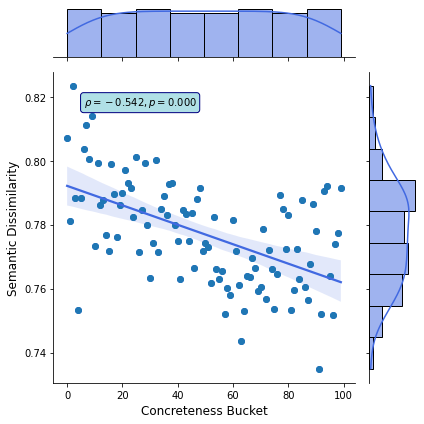

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

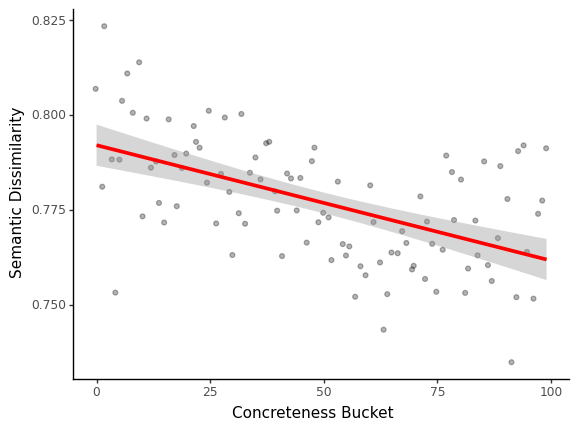

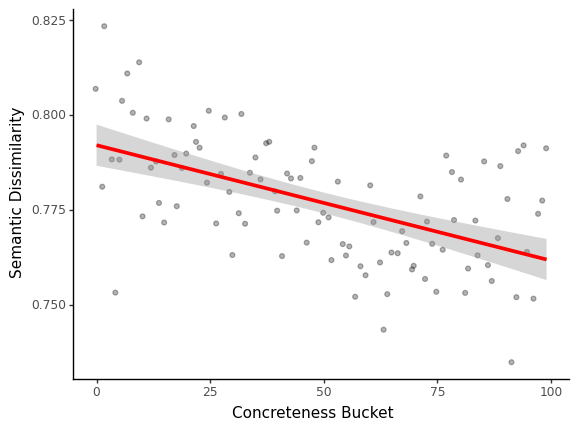

In [ ]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [ ]:
# semantic exploration 
exploration = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#determine avg concreteness 
id_concreteness = {}
for id, group in generations.groupby("id"):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

In [ ]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [ ]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

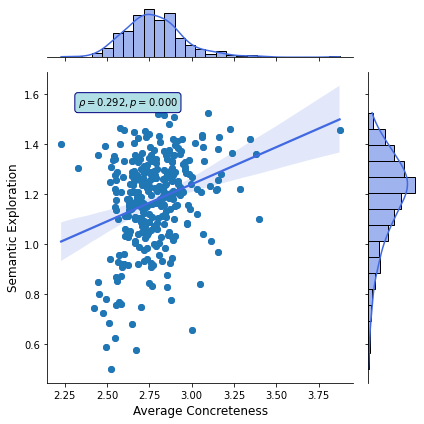

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

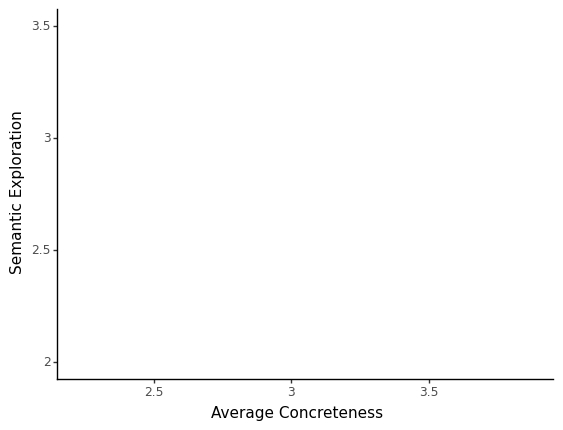

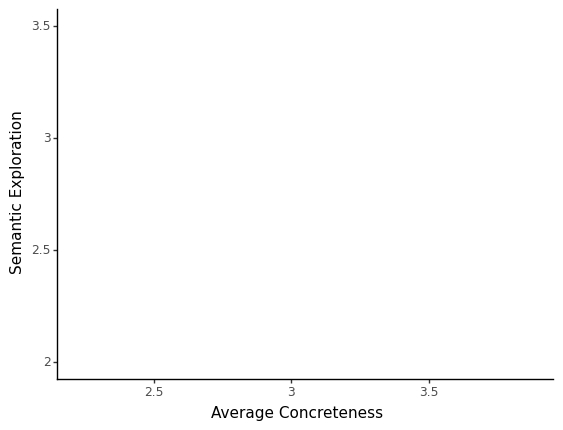

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [ ]:
concreteness = []
subjective = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


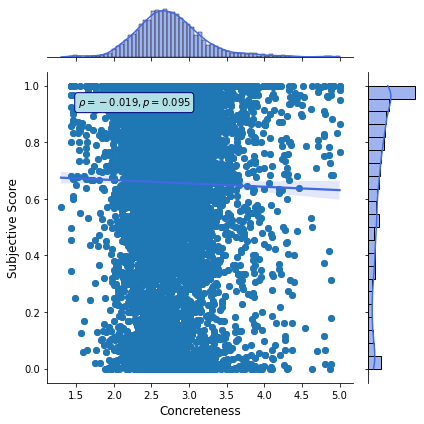

In [ ]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [ ]:
concreteness = []
sentiment = []
for response, group in generations.groupby("response"):
  words = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(words.split(" "))
  for word in words.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(sentiment_dict[response])


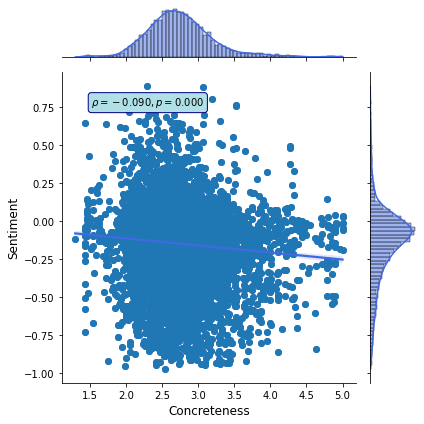

In [ ]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()